# Pattern classification: Allowing for several underlying sample sizes 

## Overview 
The main difference between this nb and `2023-07-01-model-training.ipynb` is that sample sizes are not fixed at 250 for each distribution. 

It seems that this has very minimal effect on performance. Histogram binning with 15 bins is good enough for very good classification. 


## Follow-up questions
1. Do SMEs account for the nature of the part in assigning STOW/WO labels? 
2. What's the performance on SME-labelled test data? Has our data generation captured their labeling? 

In [57]:
from scipy.stats import weibull_min, beta, gaussian_kde, norm, skewnorm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    hamming_loss,
    multilabel_confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from skmultilearn.problem_transform import LabelPowerset
import xgboost as xgb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [8]:
np.random.seed(1234)
# sample size range for each distribution
sample_size_range = [31, 200]
# number of datasets being generated per type of distribution
n_datasets = 30000
bins = 15

## early failures
the shape is in range 0.1-1.2

  0%|          | 0/60000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


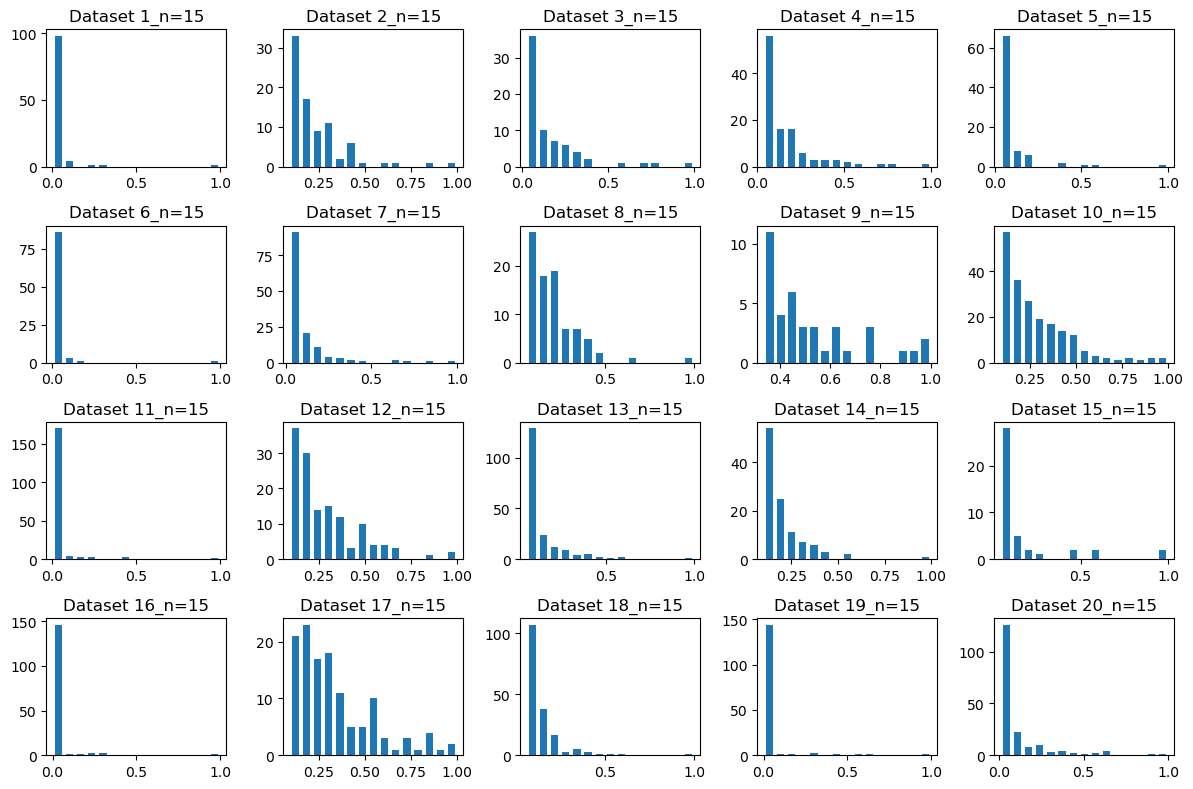

0.0 199.0


In [20]:
concat_list = []
binning_list = []
sample_sizes = []

# for infant mortality
shape_range = [0.2, 1.2]
scale_range = [0.8, 20]

for i in tqdm(range(n_datasets * 2)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    shape = np.random.uniform(shape_range[0], shape_range[1])
    scale = np.random.uniform(scale_range[0], scale_range[1])
    weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=sample_size)
    noise = np.random.normal(5, 0.1, sample_size)
    weibull_data = weibull_data + noise
    weibull_data = weibull_data / np.max(weibull_data)
    wb_data, edges = np.histogram(weibull_data, bins)
    wb_data = wb_data.astype("float32")
    concat_list.append(wb_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')

    
ef_ds = np.concatenate(concat_list)
ef_ds = ef_ds.reshape(n_datasets * 2, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(ef_ds[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

print(np.min(ef_ds), np.max(ef_ds))

## wearout distribution
generating data for wearout, shape parameter in the range 1.5 - 6

  0%|          | 0/15000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


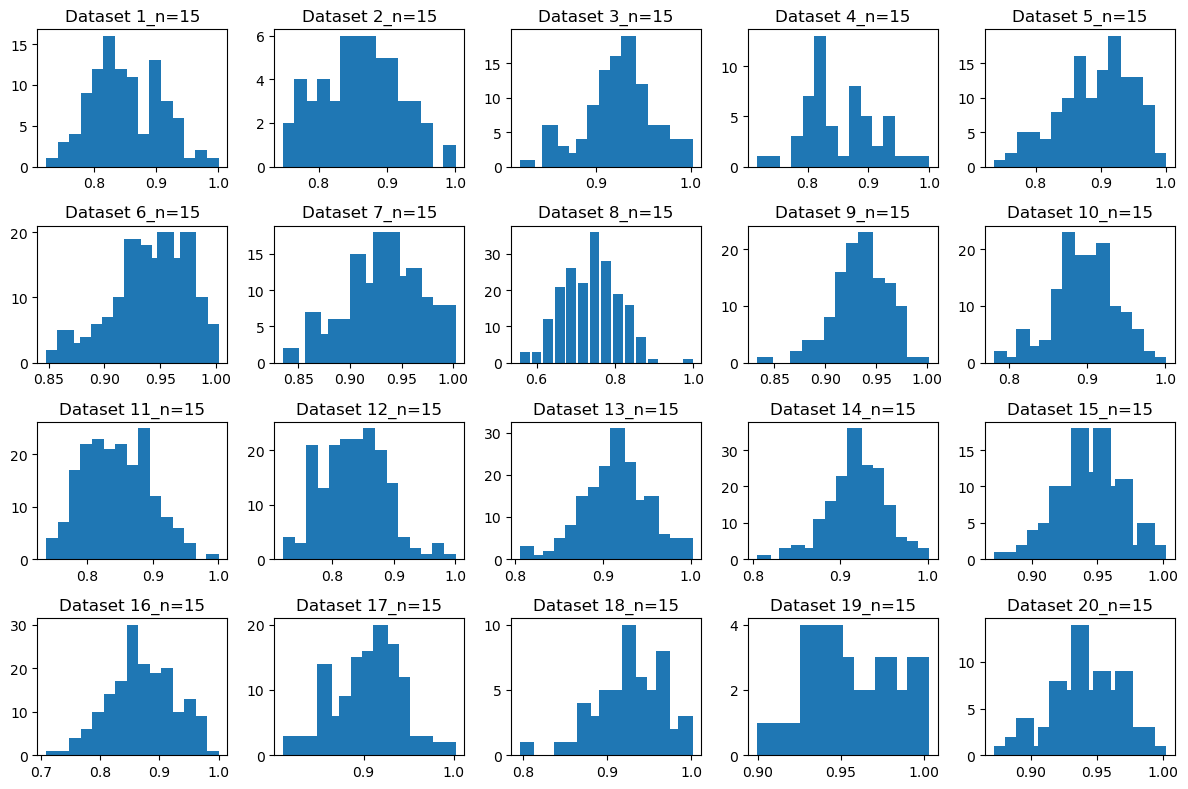

0.0 49.0


In [22]:
concat_list = []
binning_list = []
sample_sizes = []

# non-infant
shape_range = [1.5, 10]
scale_range = [0.8, 2]

for i in tqdm(range(n_datasets // 2)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    shape = np.random.uniform(shape_range[0], shape_range[1])
    scale = np.random.uniform(scale_range[0], scale_range[1])
    weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=sample_size)
    noise = np.random.normal(5, 0.1, sample_size)
    weibull_data = weibull_data + noise
    weibull_data = weibull_data / np.max(weibull_data)
    wb_data, edges = np.histogram(weibull_data, bins)
    wb_data = wb_data.astype("float32")
    concat_list.append(wb_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')

    
wo_ds = np.concatenate(concat_list)
wo_ds = wo_ds.reshape(n_datasets // 2, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(wo_ds[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

print(np.min(wo_ds), np.max(wo_ds))

## beta dist 

  0%|          | 0/15000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


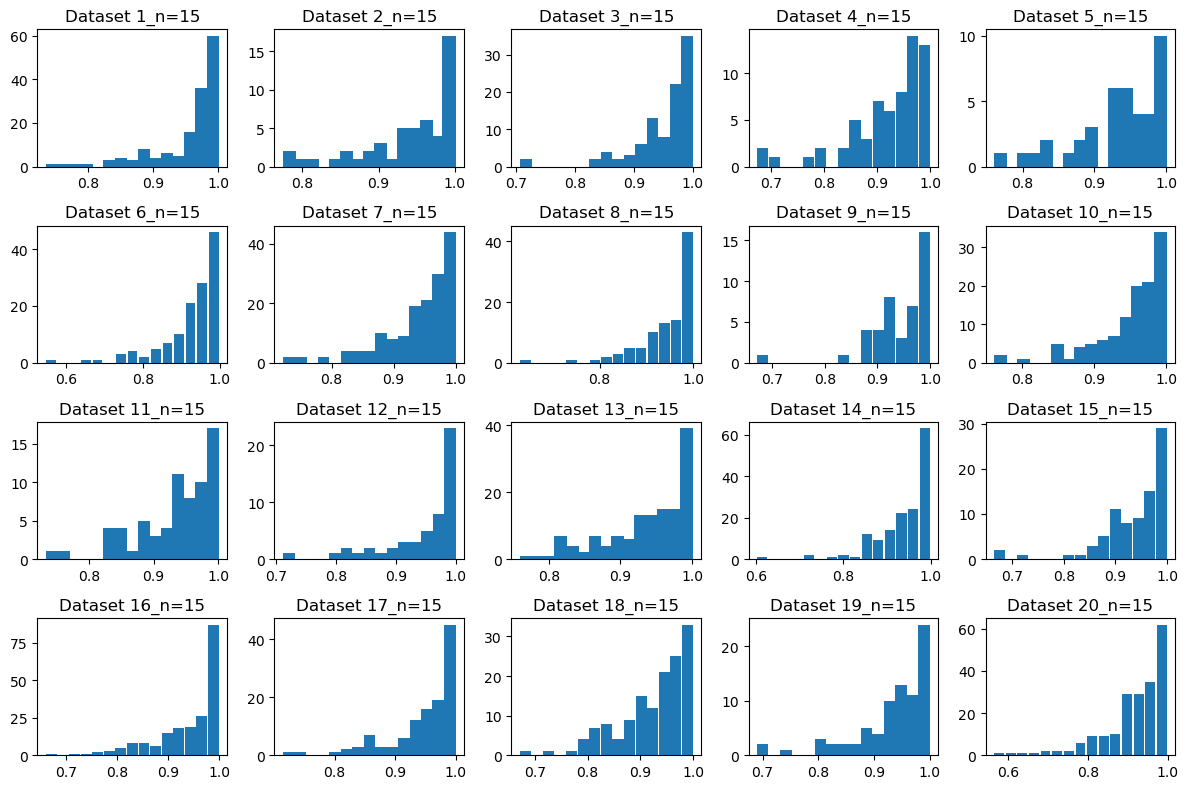

0.0 131.0


In [23]:
concat_list = []
binning_list = []
sample_sizes = []

# non-infant
alpha_range = [8, 15]
beta_range = [0.5, 1]


for i in tqdm(range(n_datasets // 2)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    alpha_val = np.random.uniform(alpha_range[0], alpha_range[1])
    beta_val = np.random.uniform(beta_range[0], beta_range[1])
    weibull_data = beta.rvs(a=alpha_val, b=beta_val, size=sample_size)
    # noise = np.random.normal(0, 0.1, sample_size)
    # weibull_data = weibull_data + noise
    weibull_data = weibull_data / np.max(weibull_data)
    wb_data, edges = np.histogram(weibull_data, bins)
    wb_data = wb_data.astype("float32")
    concat_list.append(wb_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')

    
wo_ds2 = np.concatenate(concat_list)
wo_ds2 = wo_ds2.reshape(n_datasets // 2, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(wo_ds2[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

print(np.min(wo_ds2), np.max(wo_ds2))

## bimodal_uniform

  0%|          | 0/30000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


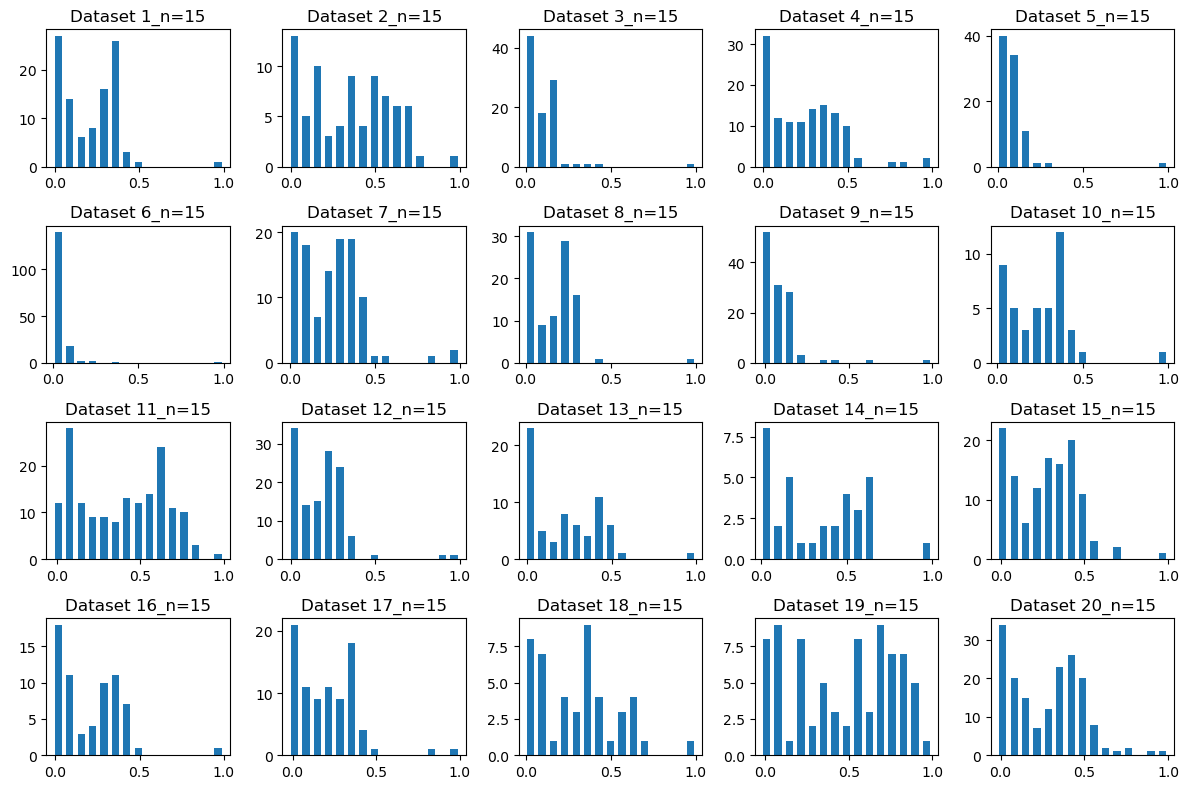

0.0 185.0


In [26]:
concat_list = []
binning_list = []
sample_sizes = []

# for bimodal
shape_range1 = [0.5, 0.8]
loc2_range = [4, 4.3]
scale2_range = [1.2, 1.7]
skew2_range = [-4.8, -5]

# scale_range = [0.8, 1.2]

for i in tqdm(range(n_datasets)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    # weibull
    shape1 = np.random.uniform(shape_range1[0], shape_range1[1])
    dist1 = weibull_min.rvs(c=shape1, scale=1, loc=0, size=sample_size // 2)
    # skew norm
    loc2 = np.random.uniform(loc2_range[0], loc2_range[1])
    scale2 = np.random.uniform(scale2_range[0], scale2_range[1])
    skew2 = np.random.uniform(skew2_range[0], skew2_range[1])
    dist2 = skewnorm.rvs(skew2, loc=loc2, scale=scale2, size=sample_size // 2)
    # concatenate both samples
    sample = np.concatenate([dist1, dist2])
    # noise
    noise = np.random.normal(0, 0.1, len(sample))
    sample = sample + noise
    # max scaling
    sample = sample / np.max(sample)
    # bin into histogram, get counts and edges
    sample_data, edges = np.histogram(sample, bins)
    sample_data = sample_data.astype("float32")
    # append to list
    concat_list.append(sample_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')

bm_ds = np.concatenate(concat_list)
bm_ds = bm_ds.reshape(n_datasets, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(bm_ds[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

print(np.min(bm_ds), np.max(bm_ds))

## skewed normal 

  0%|          | 0/30000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


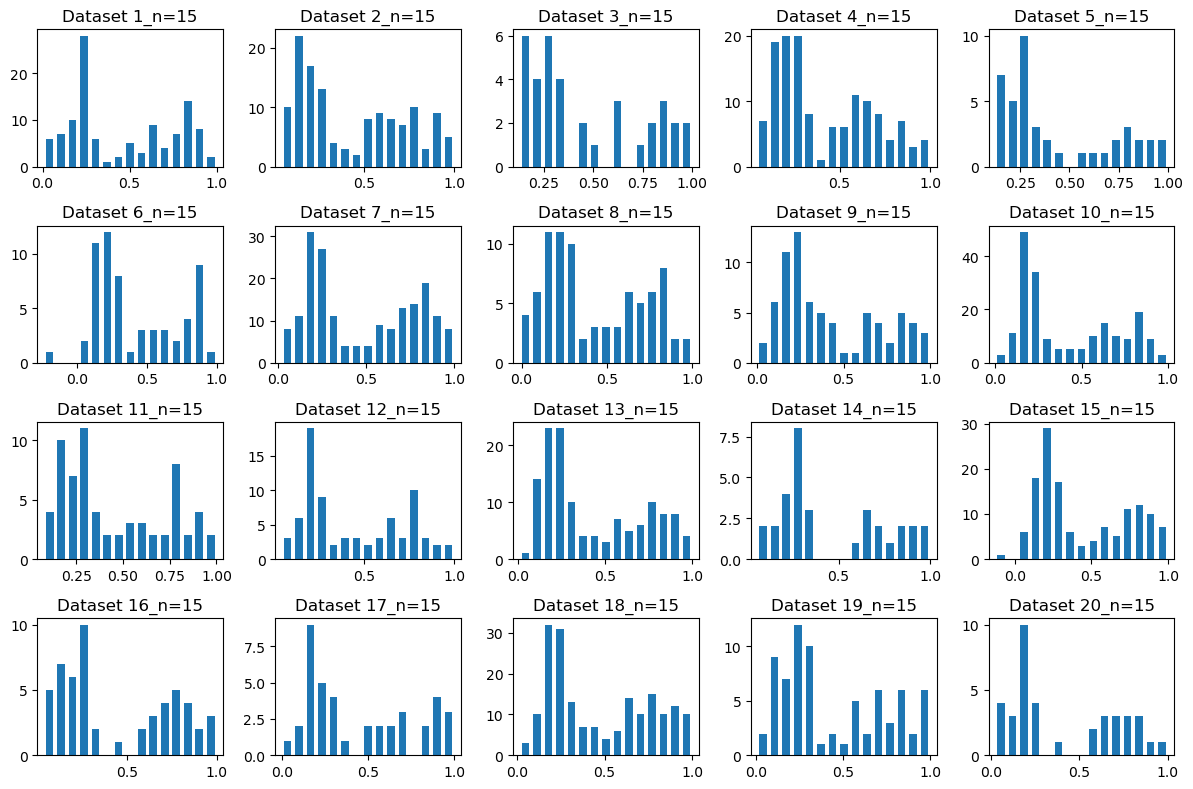

0.0 69.0


In [28]:
concat_list = []
binning_list = []
sample_sizes = []

# for bimodal
shape_range1 = [2.5, 4]
loc2_range = [4, 4.3]
scale2_range = [1.2, 1.7]
skew2_range = [-4.8, -5]

# scale_range = [0.8, 1.2]

for i in tqdm(range(n_datasets)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    # weibull
    shape1 = np.random.uniform(shape_range1[0], shape_range1[1])
    dist1 = weibull_min.rvs(c=shape1, scale=1, loc=0, size=sample_size // 2)
    # skew norm
    loc2 = np.random.uniform(loc2_range[0], loc2_range[1])
    scale2 = np.random.uniform(scale2_range[0], scale2_range[1])
    skew2 = np.random.uniform(skew2_range[0], skew2_range[1])
    dist2 = skewnorm.rvs(skew2, loc=loc2, scale=scale2, size=sample_size // 2)
    # concatenate both samples
    sample = np.concatenate([dist1, dist2])
    # noise
    noise = np.random.normal(0, 0.1, len(sample))
    sample = sample + noise
    # max scaling
    sample = sample / np.max(sample)
    # bin into histogram, get counts and edges
    sample_data, edges = np.histogram(sample, bins)
    sample_data = sample_data.astype("float32")
    # append to list
    concat_list.append(sample_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')

bm_ds2 = np.concatenate(concat_list)
bm_ds2 = bm_ds2.reshape(n_datasets, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(bm_ds2[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

print(np.min(bm_ds2), np.max(bm_ds2))

# uniform dist 

  0%|          | 0/30000 [00:00<?, ?it/s]

Min sample size: 31
Max sample size: 200


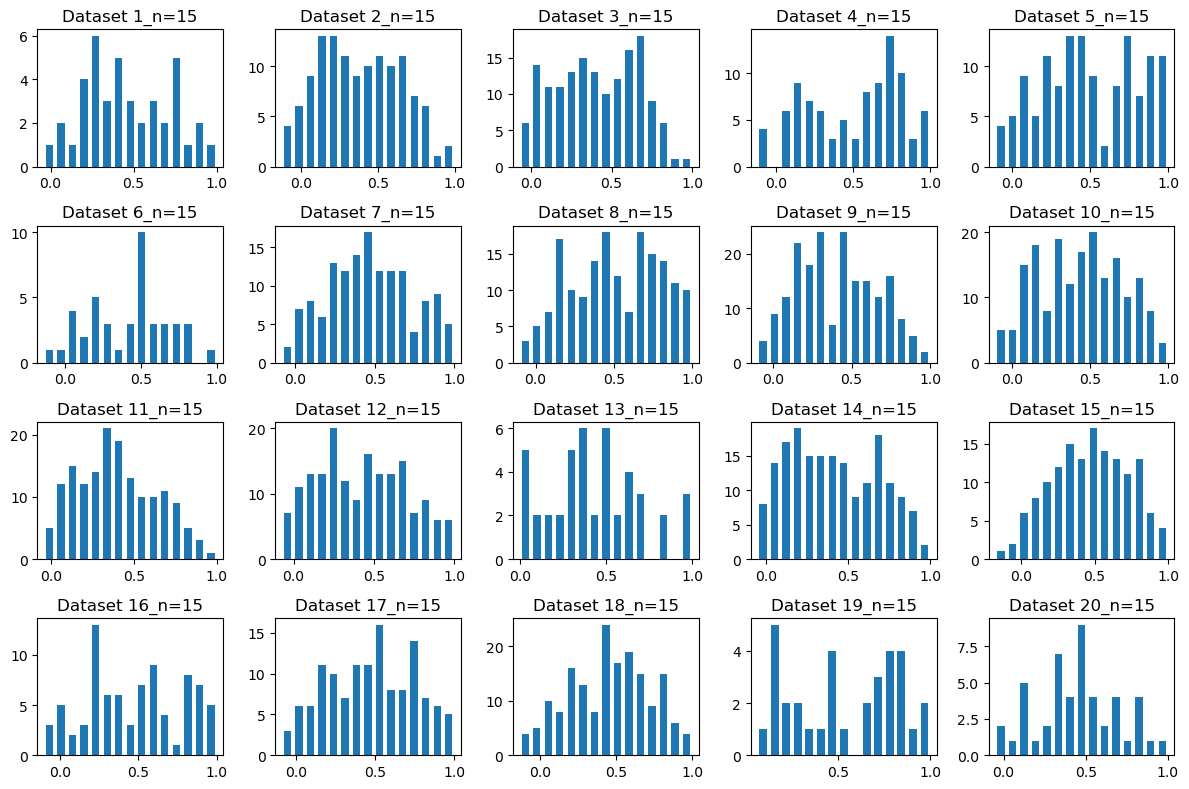

In [29]:
concat_list = []
binning_list = []
sample_sizes = []

for i in tqdm(range(n_datasets)):
    sample_size = np.random.randint(sample_size_range[0], sample_size_range[1] + 1)
    sample_sizes.append(sample_size)
    sample = np.random.uniform(0, 1, sample_size)
    # noise
    noise = np.random.normal(0, 0.1, sample_size)
    sample = sample + noise
    # max scaling
    sample = sample / np.max(sample)
    # bin into histogram, get counts and edges
    sample_data, edges = np.histogram(sample, bins)
    sample_data = sample_data.astype("float32")
    # append to list
    concat_list.append(sample_data)
    binning_list.append(edges)

print(f'Min sample size: {np.min(np.array(sample_sizes))}')
print(f'Max sample size: {np.max(np.array(sample_sizes))}')
    
uni_ds = np.concatenate(concat_list)
uni_ds = uni_ds.reshape(n_datasets, bins)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))
axs = axs.flatten()
for i, dataset in enumerate(uni_ds[:20]):
    edges = binning_list[i]
    binning = []

    for j, item in enumerate(edges):
        if j + 1 < len(edges):
            size = (edges[j + 1] - edges[j]) / 2
            binning.append(edges[j] + size)

    axs[i].bar(binning, dataset, width=size + 0.01)
    axs[i].set_title(f"Dataset {i + 1}_n={dataset.shape[0]}")

plt.tight_layout()
plt.show()

# Data prep

In [40]:
# binning feature matrix
X = np.concatenate([ef_ds, wo_ds, wo_ds2, bm_ds, bm_ds2])
X.shape

(150000, 15)

In [41]:
# Y classes
ef_ds_ef_class = np.ones(n_datasets * 2, dtype=np.float32)
ef_ds_wo_class = np.zeros(n_datasets * 2, dtype=np.float32)
wo_ds_ef_class = np.zeros(n_datasets, dtype=np.float32)
wo_ds_wo_class = np.ones(n_datasets, dtype=np.float32)
# uni_ds_ef_class = np.zeros(n_datasets, dtype=np.float32)  # todo: confirm: uniforms are neither ef nor wo? 
# uni_ds_wo_class = np.zeros(n_datasets, dtype=np.float32)
bm_ds_ef_class = np.ones(n_datasets, dtype=np.float32)
bm_ds_wo_class = np.ones(n_datasets, dtype=np.float32)
bm_ds2_ef_class = np.zeros(n_datasets, dtype=np.float32)
bm_ds2_wo_class = np.ones(n_datasets, dtype=np.float32)
y_ef_class = np.concatenate(
    [ef_ds_ef_class, wo_ds_ef_class, bm_ds_ef_class, bm_ds2_ef_class]
)
y_wo_class = np.concatenate(
    [ef_ds_wo_class, wo_ds_wo_class, bm_ds_wo_class, bm_ds2_wo_class]
)

assert y_ef_class.shape == y_wo_class.shape == (150_000,)

y = np.column_stack([y_ef_class, y_wo_class])

In [55]:
# test train split
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1221
)
# val train split
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_and_val, y_train_and_val, test_size=0.25, random_state=1111
)

X_train.shape
X_valid.shape 

y_train.shape
y_valid.shape


(90000, 15)

(30000, 15)

(90000, 2)

(30000, 2)

# Models 

In [53]:
model_dict = {
    0: LabelPowerset(LogisticRegression(multi_class='multinomial', random_state=11)), 
    1: LabelPowerset(RandomForestClassifier(random_state=11)), 
    2: LabelPowerset(xgb.XGBClassifier(objective="multi:softmax", random_state=11))
}

# Train and eval functions 

In [61]:
def train_model(model_num, X_train=X_train, y_train=y_train, X_valid=X_valid): 
    m = model_dict.get(model_num)
    m.fit(X_train, y_train)
    preds = m.predict(X_valid)
    return preds 

def evaluate_model(y, y_pred, model_desc=''): 
    cr = classification_report(y, y_pred)
    print(cr) 
    
    cm = multilabel_confusion_matrix(y, y_pred)
    print(cm)
    print('true_label from top to bottom; predicted_label from left to right')
    
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     fig, ax = plt.subplots(figsize=(5, 5))
#     disp.plot(ax=ax, cmap=plt.cm.Blues)
#     plt.title(f'{model_desc}')
#     plt.xlabel("predicted label")
#     plt.ylabel("true label")
#     plt.plot()
    pass 
    

def train_eval_pipeline(model_num, _X_train=X_train, _y_train=y_train, _X_valid=X_valid, _y_valid=y_valid): 
    model_desc = model_dict.get(model_num)
    print(f'\n\nmodel: {model_desc}')
    preds_valid = train_model(model_num, _X_train, _y_train, _X_valid)
    evaluate_model(_y_valid, preds_valid, model_desc)

# Training and model selection

In [62]:
for model in model_dict.keys(): 
    train_eval_pipeline(model)



model: LabelPowerset(classifier=LogisticRegression(multi_class='multinomial',
                                            random_state=11),
              require_dense=[True, True])


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.98      0.95      0.97     17979
           1       0.92      0.91      0.91     18111

   micro avg       0.95      0.93      0.94     36090
   macro avg       0.95      0.93      0.94     36090
weighted avg       0.95      0.93      0.94     36090
 samples avg       0.97      0.96      0.95     36090

[[[11755   266]
  [  906 17073]]

 [[10460  1429]
  [ 1639 16472]]]
true_label from top to bottom; predicted_label from left to right


model: LabelPowerset(classifier=RandomForestClassifier(random_state=11),
              require_dense=[True, True])
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     17979
           1       0.99      0.99      0.99     18111

   micro avg       0.99      0.99      0.99     36090
   macro avg       0.99      0.99      0.99     36090
weighted avg       0.99      0.99      0.99     36090
 samples avg       1.00      0.99      0.9